# License Plate Recognition (Character Recognition) using OpenCV and CNN

### Project by Team 2

### Importing Necessary Libraries

In [1]:
import cv2
import imutils
import os
import inspect
import numpy as np
import matplotlib.pyplot as plt
import argparse
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
import functools
import tensorflow as tf
from sklearn.metrics import f1_score
from keras.layers import BatchNormalization
from keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

2022-12-08 09:34:45.169911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Checking Image Charactistics 

In [2]:
image_input = cv2.imread('/Users/Manisha/Desktop/image_licenseplate6.jpeg')
ht, wdh = image_input.shape[:2]
print(ht)
print(wdh)

701
1050


In [3]:
image_input = imutils.resize(image_input, width=400)


In [4]:
cv2.imshow("Image_Original", image_input)
#cv2.waitKey(0)

In [5]:
image_grey = cv2.cvtColor(image_input, cv2.COLOR_BGR2GRAY)
cv2.imshow("Image_Grey", image_grey)
#cv2.waitKey(0)

### Preprocessing the image

In [6]:
thresh_otsu, _ = cv2.threshold(image_grey, 0, 255, cv2.THRESH_OTSU)
thresh_triangle, _ = cv2.threshold(image_grey, 0, 255, cv2.THRESH_TRIANGLE)
thresh_manual = np.median(image_grey)

def input_thresh(threshold, sigma=0.33):
    return (1-sigma) * threshold, (1+sigma) * threshold

thresh_otsu = input_thresh(thresh_otsu)
thresh_triangle = input_thresh(thresh_triangle)
thresh_manual = input_thresh(thresh_manual)

print(f"Otsu's Threshold: {thresh_otsu} \nTriangle Threshold: {thresh_triangle} \nManual Threshold: {thresh_manual}")

Otsu's Threshold: (67.66999999999999, 134.33) 
Triangle Threshold: (5.359999999999999, 10.64) 
Manual Threshold: (20.099999999999998, 39.900000000000006)


# Detecting edges

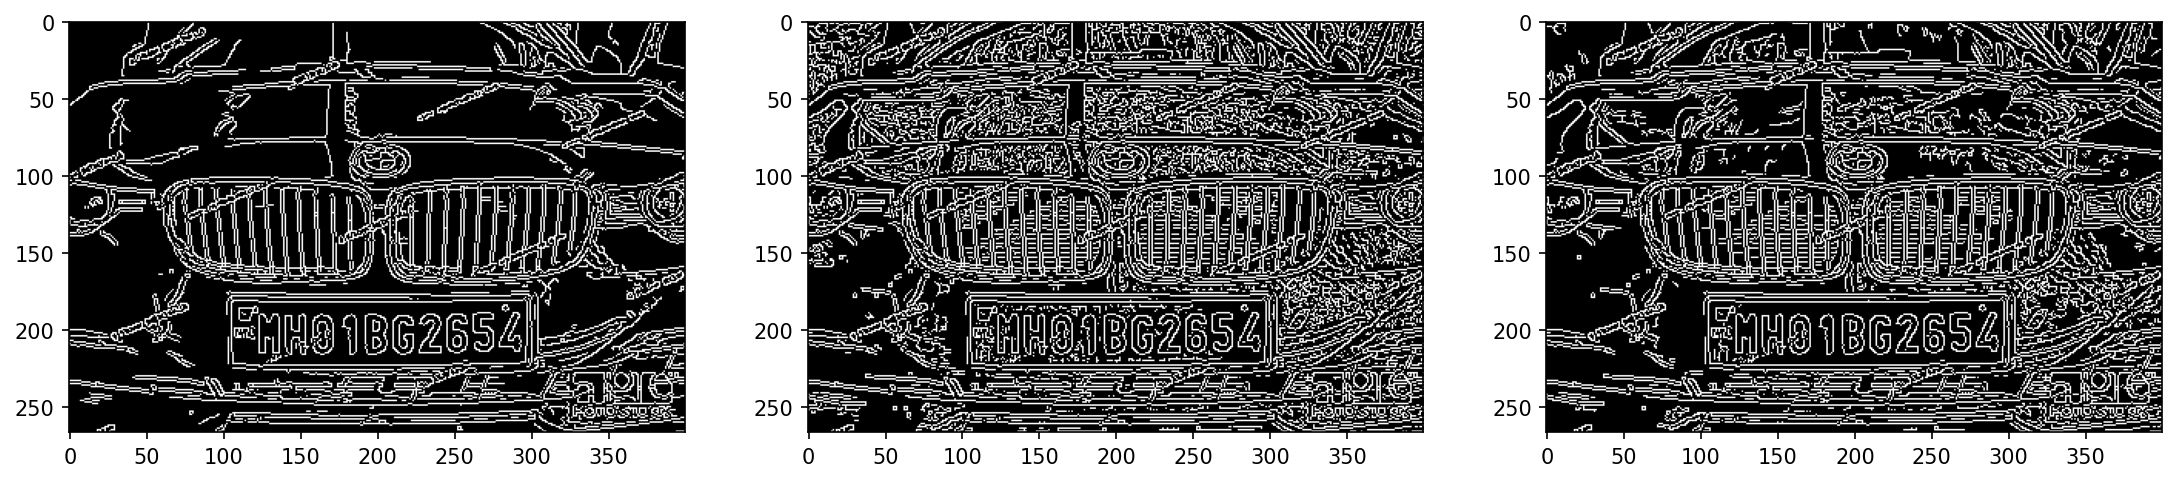

In [7]:
edge_otsu = cv2.Canny(image_grey, *thresh_otsu)
edge_triangle = cv2.Canny(image_grey, *thresh_triangle)
edge_manual = cv2.Canny(image_grey, *thresh_manual)

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
ax[0].imshow(edge_otsu, cmap='gray')
ax[1].imshow(edge_triangle, cmap='gray')
ax[2].imshow(edge_manual, cmap='gray')

In [8]:
image_edged = cv2.Canny(image_grey, 77, 152) 
cv2.imshow("Image_Edged", image_edged)
#cv2.waitKey(0)

# Contours

In [9]:
contours, hierarchy = cv2.findContours(image_edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image for `CHAIN_APPROX_SIMPLE`
image_input_cnt = image_input.copy()
cv2.drawContours(image_input_cnt, contours, -1, (0, 255, 0), 2, cv2.LINE_AA)
# see the results
cv2.imshow('Image_Contours', image_input_cnt)
#cv2.waitKey(0)


In [10]:
cntrs = sorted(contours, key = cv2.contourArea, reverse = True) [:2]
platecnt = None
image_input_cnt2 = image_input.copy()
cv2.drawContours(image_input_cnt2,cntrs,-1,(0,255,0),3)
cv2.imshow("Top 2 contours",image_input_cnt2)
#cv2.waitKey(0)

In [11]:
i='Cropped'
for c in cntrs:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        if len(approx) == 4: 
                platecnt = approx

        x,y,w,h = cv2.boundingRect(c) 
        image_plate=image_input[y:y+h,x:x+w]
        cv2.imwrite((i)+'.png',image_plate)
        break

### Cropped image license plate

In [12]:
cv2.drawContours(image_input, [platecnt], -1, (0, 255, 0), 3)
cv2.imshow("Detected license plate", image_input)
#cv2.waitKey(0)

In [13]:
License_Plate = 'Cropped.png'
cv2.imshow("cropped", cv2.imread(License_Plate))


In [14]:
image_plate = cv2.imread('/Users/Manisha/Cropped.png')

In [15]:
image_plate = cv2.resize(image_plate, (333, 75))
image_grey_plate = cv2.cvtColor(image_plate, cv2.COLOR_BGR2GRAY)
_, image_binary_plate = cv2.threshold(image_grey_plate, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#image_binary_plate = cv2.erode(img_binary_lp, (3,3))
#image_binary_plate = cv2.dilate(img_binary_lp, (3,3))
    
    

In [16]:
print(image_binary_plate.shape)


(75, 333)


In [17]:
#whitening out remaining area
image_binary_plate[0:4,:] = 255
image_binary_plate[:,0:4] = 255
image_binary_plate[75:,:] = 255
image_binary_plate[:,333:] = 255


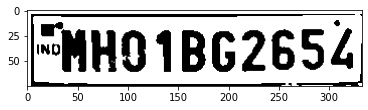

True

In [18]:
LP_WIDTH = image_binary_plate.shape[0]
LP_HEIGHT = image_binary_plate.shape[1]


limits = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
plt.imshow(image_binary_plate, cmap='gray')
plt.show()
cv2.imwrite('Cropped_grey.jpg',image_binary_plate)

In [19]:
print(limits)

[12.5, 37.5, 33.3, 222.0]


In [20]:
# Find all contours in the image
contours, _  = cv2.findContours(image_binary_plate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Retrieve potential dimensions
width_lowerlimit = limits[0]
width_upperlimit = limits[1]
height_lowerlimit = limits[2]
height_upperlimit = limits[3]
    
# Check largest 5 or  15 contours for license plate or character respectively
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    
image_plate_grey = cv2.imread('Cropped_grey.jpg')
    


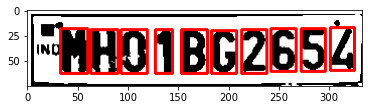

In [21]:
cntr_list = []
target_contours = []
ch_seg = []
for c in contours :
    # detects contour in binary image and returns the coordinates of rectangle enclosing it
    intX, intY, intWidth, intHeight = cv2.boundingRect(c)
        
    # checking the dimensions of the contour to filter out the characters by contour's size
    if intWidth > width_lowerlimit and intWidth < width_upperlimit and intHeight > height_lowerlimit and intHeight < height_upperlimit :
        cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

        char_copy = np.zeros((44,24))
        # extracting each character using the enclosing rectangle's coordinates.
        char = image_binary_plate[intY:intY+intHeight, intX:intX+intWidth]
        char = cv2.resize(char, (20, 40))
        
            
        cv2.rectangle(image_plate_grey, (intX,intY), (intWidth+intX, intY+intHeight), (255,0,0), 2)
        #plt.imshow(image_plate_grey, cmap='gray')

        # Make result formatted for classification: invert colors
        char = cv2.subtract(255, char)
        # Resize the image to 24x44 with black border
        char_copy[2:42, 2:22] = char
        char_copy[0:2, :] = 0
        char_copy[:, 0:2] = 0
        char_copy[42:44, :] = 0
        char_copy[:, 22:24] = 0
        
        ch_seg.append(char_copy)
plt.imshow(image_plate_grey, cmap='gray')

            

In [22]:
# arbitrary function that stores sorted list of character indeces
indices = sorted(range(len(cntr_list)), key=lambda k: cntr_list[k])
ch_seg_copy = []
for idx in indices:
    ch_seg_copy.append(ch_seg[idx])# stores character images according to their index
ch_seg = np.array(ch_seg_copy)


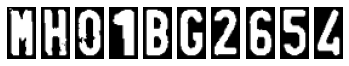

In [23]:
for i in range(len(cntr_list)):
    plt.subplot(1, len(cntr_list), i+1)
    plt.imshow(ch_seg_copy[i], cmap='gray')
    plt.axis('off')

### Data Augmentation 

In [24]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
src_path = '/Users/Manisha/data'

train_generator=train_datagen.flow_from_directory(
src_path+'/train',
batch_size=1,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,32))

valid_generator=valid_datagen.flow_from_directory(
src_path+'/val',
batch_size=1,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,32))


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


### Build the model with 2 Convolution, 2 Max Pooling Layers followed by Dense layers

In [26]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(36))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

2022-12-08 09:35:40.110931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/abhilash/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

### Training the model with 150 epochs

In [32]:
batch_size = 1
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = valid_generator, 
      epochs = 150, verbose=1)

Epoch 1/150
 22/864 [..............................] - ETA: 4s - loss: 0.1490 - accuracy: 1.0000

/var/folders/pd/gpgs3lh15wx458zc6_s0w4100000gp/T/ipykernel_30488/2331585519.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


864/864 [==============================] - 4s 4ms/step - loss: 0.2926 - accuracy: 0.9051 - val_loss: 0.2443 - val_accuracy: 0.9352
Epoch 2/150
864/864 [==============================] - 4s 4ms/step - loss: 0.2971 - accuracy: 0.9028 - val_loss: 0.1109 - val_accuracy: 0.9722
Epoch 3/150
864/864 [==============================] - 4s 4ms/step - loss: 0.2596 - accuracy: 0.9086 - val_loss: 0.1136 - val_accuracy: 0.9630
Epoch 4/150
864/864 [==============================] - 4s 4ms/step - loss: 0.2409 - accuracy: 0.9178 - val_loss: 0.1721 - val_accuracy: 0.9259
Epoch 5/150
864/864 [==============================] - 4s 4ms/step - loss: 0.2280 - accuracy: 0.9225 - val_loss: 0.2058 - val_accuracy: 0.9444
Epoch 6/150
864/864 [==============================] - 4s 4ms/step - loss: 0.2090 - accuracy: 0.9317 - val_loss: 0.0845 - val_accuracy: 0.9722
Epoch 7/150
864/864 [==============================] - 4s 4ms/step - loss: 0.2116 - accuracy: 0.9340 - val_loss: 0.0619 - val_accuracy: 0.9815
Epoch 8/150

864/864 [==============================] - 3s 4ms/step - loss: 0.0605 - accuracy: 0.9780 - val_loss: 0.0360 - val_accuracy: 0.9815
Epoch 59/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0419 - accuracy: 0.9826 - val_loss: 0.0234 - val_accuracy: 0.9907
Epoch 60/150
864/864 [==============================] - 4s 4ms/step - loss: 0.0573 - accuracy: 0.9769 - val_loss: 0.0782 - val_accuracy: 0.9676
Epoch 61/150
864/864 [==============================] - 4s 5ms/step - loss: 0.0528 - accuracy: 0.9792 - val_loss: 0.0612 - val_accuracy: 0.9676
Epoch 62/150
864/864 [==============================] - 4s 5ms/step - loss: 0.0539 - accuracy: 0.9780 - val_loss: 0.0372 - val_accuracy: 0.9954
Epoch 63/150
864/864 [==============================] - 4s 5ms/step - loss: 0.0507 - accuracy: 0.9826 - val_loss: 0.0421 - val_accuracy: 0.9861
Epoch 64/150
864/864 [==============================] - 5s 5ms/step - loss: 0.0371 - accuracy: 0.9884 - val_loss: 0.0503 - val_accuracy: 0.9769
Epoch

Epoch 115/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0289 - accuracy: 0.9861 - val_loss: 0.0397 - val_accuracy: 0.9815
Epoch 116/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0396 - accuracy: 0.9850 - val_loss: 0.1301 - val_accuracy: 0.9815
Epoch 117/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0348 - accuracy: 0.9803 - val_loss: 0.0952 - val_accuracy: 0.9583
Epoch 118/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0267 - accuracy: 0.9896 - val_loss: 0.0858 - val_accuracy: 0.9676
Epoch 119/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0330 - accuracy: 0.9873 - val_loss: 0.0485 - val_accuracy: 0.9815
Epoch 120/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0401 - accuracy: 0.9826 - val_loss: 0.0561 - val_accuracy: 0.9815
Epoch 121/150
864/864 [==============================] - 3s 4ms/step - loss: 0.0221 - accuracy: 0.9919 - val_loss: 0.0425 - val_ac

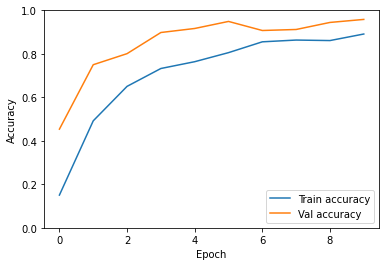

In [29]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Val accuracy')
  plt.legend()
  plt.ylim([0, 1])

plot_history(history)

### Model Prediction

In [30]:
def ch_predicted():
    ch_dict = {}
    charac_all = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i,c in enumerate(charac_all):
        ch_dict[i] = c

    output = []
    for i,ch in enumerate(ch_seg_copy): #iterating over the characters
        image = cv2.resize(ch, (32,32), interpolation=cv2.INTER_AREA)
        resized_image = np.zeros((32,32,3))
        for i in range(3):
            resized_image[:,:,i] = image
        image = resized_image.reshape(1,32,32,3) #preparing image for the model
        prediction = model.predict(image)[0] #predicting the class
        y=np.argmax(prediction)

        predicted_character = ch_dict[y] #
        output.append(predicted_character) #storing the result in a list

    predicted_plate_number = ''.join(output)
    
    return predicted_plate_number

print(ch_predicted())

1/1 [==============================] - 0s 25ms/step
WH01BG2854


1/1 [==============================] - 0s 31ms/step


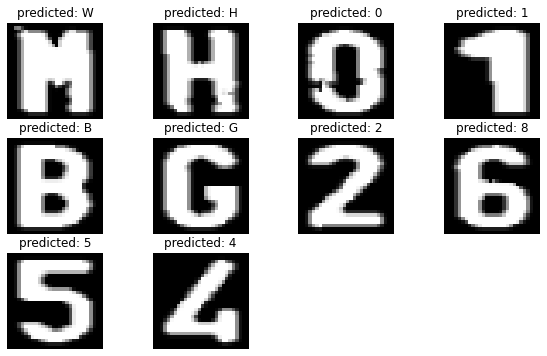

In [31]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(ch_seg_copy):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {ch_predicted()[i]}')
    plt.axis('off')
plt.show()

### Model with more convolution and max pooling layers and BatchNormalization

In [53]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Conv2D(32,(3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
# Output classes are 36
model1.add(Dense(36))
model1.add(Activation('softmax'))


model1.compile(loss='sparse_categorical_crossentropy', 
               optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [40]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_16 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 activation_17 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                  

1/1 [==============================] - 0s 12ms/step


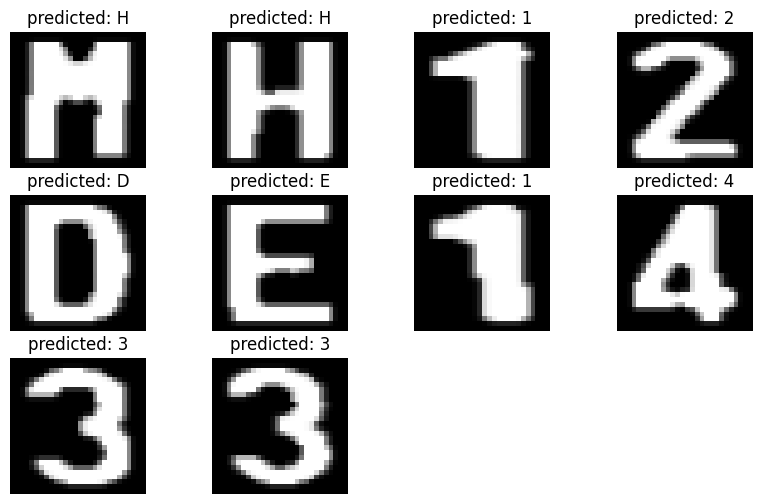

In [41]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(ch_seg_copy):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {ch_predicted()[i]}')
    plt.axis('off')
plt.show()

In [51]:
#class stop_training_callback(tf.keras.callbacks.Callback):   
 #   def on_epoch_end(self, epoch, logs={}):
 #       if(logs.get('val_custom_f1score') > 0.99):
  #          self.model.stop_training = True

In [42]:
batch_size = 1
# callbacks = [stop_training_callback()]
history1 = model1.fit_generator(
      train_generator,
      validation_data = valid_generator, 
      epochs = 150, verbose=1)

/var/folders/9j/z5w1t_zd5kb07wyrgftr6ks80000gn/T/ipykernel_30222/3334900722.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(


Epoch 1/150
864/864 [==============================] - 4s 4ms/step - loss: 2.5101 - accuracy: 0.3171 - val_loss: 1.0589 - val_accuracy: 0.6713
Epoch 2/150
864/864 [==============================] - 3s 4ms/step - loss: 1.1197 - accuracy: 0.6285 - val_loss: 0.6245 - val_accuracy: 0.7824
Epoch 3/150
864/864 [==============================] - 3s 4ms/step - loss: 0.6916 - accuracy: 0.7870 - val_loss: 0.4877 - val_accuracy: 0.8241
Epoch 4/150
864/864 [==============================] - 3s 4ms/step - loss: 0.5383 - accuracy: 0.8113 - val_loss: 0.4241 - val_accuracy: 0.8796
Epoch 5/150
864/864 [==============================] - 3s 4ms/step - loss: 0.4671 - accuracy: 0.8310 - val_loss: 0.2966 - val_accuracy: 0.8843
Epoch 6/150
864/864 [==============================] - 3s 4ms/step - loss: 0.3615 - accuracy: 0.8981 - val_loss: 0.3685 - val_accuracy: 0.8241
Epoch 7/150
864/864 [==============================] - 3s 4ms/step - loss: 0.3565 - accuracy: 0.8796 - val_loss: 0.1645 - val_accuracy: 0.9120

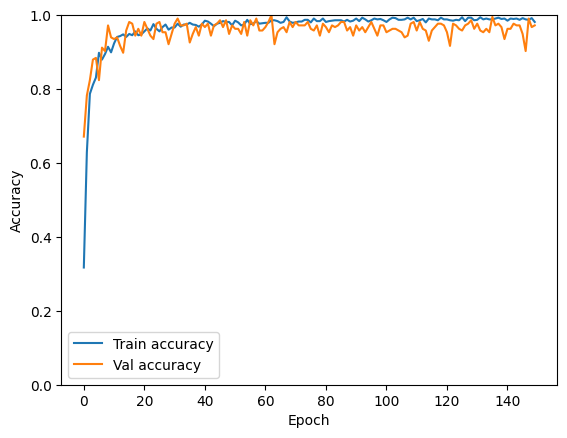

In [66]:
plot_history(history1)

### Model -3 Call backs and dropouts

In [58]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(32,(3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(Dense(36))
model2.add(Activation('softmax'))


model2.compile(loss='sparse_categorical_crossentropy', 
               optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [61]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.99):
      self.model.stop_training = True

In [62]:
batch_size = 1
callbacks = [stop_training_callback()]
history2 = model2.fit_generator(
      train_generator,callbacks=callbacks,
      validation_data = valid_generator, 
      epochs = 150, verbose=1)

Epoch 1/150
 14/864 [..............................] - ETA: 3s - loss: 3.0275 - accuracy: 0.2143     

/var/folders/9j/z5w1t_zd5kb07wyrgftr6ks80000gn/T/ipykernel_30222/858110533.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(


864/864 [==============================] - 3s 4ms/step - loss: 2.3668 - accuracy: 0.3090 - val_loss: 1.3505 - val_accuracy: 0.6296
Epoch 2/150
864/864 [==============================] - 3s 4ms/step - loss: 1.7530 - accuracy: 0.4456 - val_loss: 0.9809 - val_accuracy: 0.7315
Epoch 3/150
864/864 [==============================] - 3s 4ms/step - loss: 1.3723 - accuracy: 0.5775 - val_loss: 0.7218 - val_accuracy: 0.7778
Epoch 4/150
864/864 [==============================] - 4s 4ms/step - loss: 1.1099 - accuracy: 0.6238 - val_loss: 0.5067 - val_accuracy: 0.8426
Epoch 5/150
864/864 [==============================] - 4s 4ms/step - loss: 0.9685 - accuracy: 0.6829 - val_loss: 0.4543 - val_accuracy: 0.8565
Epoch 6/150
864/864 [==============================] - 3s 4ms/step - loss: 0.7694 - accuracy: 0.7477 - val_loss: 0.3295 - val_accuracy: 0.8935
Epoch 7/150
864/864 [==============================] - 3s 4ms/step - loss: 0.7452 - accuracy: 0.7442 - val_loss: 0.2912 - val_accuracy: 0.9028
Epoch 8/150

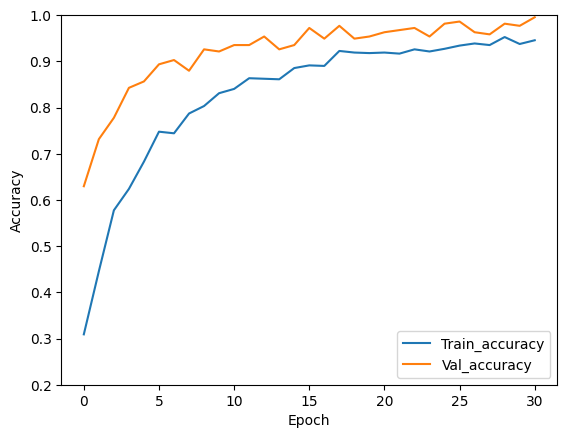

In [68]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Train_accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Val_accuracy')
  plt.legend()
  plt.ylim([0.2, 1])

plot_history(history2)